## Data homogenization elevation and sensor height

This notebook performs the first set of data homogenization and corrections to account for elevation changes sensor height.

In [1]:
import pandas as pd
import os
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

thedir = os.getcwd()
datadir_ = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/external'))
datadir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/raw'))
writedir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/interim'))
figdir=os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'figures'))

In [2]:
# sensor height corrections (3m sensors, 2m height of ref measurement)
# select using entire data set and pull out July observations.

# load reference data set
df_ = pd.read_csv(F'{datadir_}/2018_Stadtklimamessnetz_Rohdaten-2m-3m-ref.csv')

# date time conversion function
def dt_func(x):
    return dt.datetime.strptime(x,"%m/%d/%Y %H:%M")

# return hour
def hr_func(x):
    return x.hour

# return month
def mon_func(x):
    return x.month

df_["time"]= df_.Zeit.apply(lambda x: dt_func(x))
df_['hour'] = df_['time'].apply(lambda x: hr_func(x))
df_["month"] = df_.time.apply(lambda x: mon_func(x))
df_j = df_[df_.month == 7].copy()

### Sensor height homogenization

The sensors are placed at 3m heights but WMO guidelines indicate that temperature measurements are taken at 2m heights. Thus the data must be adjusted. This initial analysis uses four methods:
* hour by hour step function using all monthly data from 2018 (for now, will go to all previous years soon)
* hour by hour step function using only July data

In [3]:
# get mean difference and sum of squared differences.

df_['diff_'] = df_.Log_98_REF_ZOLL_2m - df_.Log_99_ZOLL_3m
sample_mean = (df_.diff_.sum())/len(df_)
df_['sq_diff'] = (df_.Log_98_REF_ZOLL_2m - df_.Log_99_ZOLL_3m-sample_mean)**2
sample_var = (df_.sq_diff.sum())/len(df_)
hours = df_.groupby("hour").agg({'diff_':['mean','var']})

df_j['diff_'] = df_j.Log_98_REF_ZOLL_2m - df_j.Log_99_ZOLL_3m
sample_mean_j = (df_j.diff_.sum())/len(df_j)
df_j['sq_diff'] = (df_j.Log_98_REF_ZOLL_2m - df_j.Log_99_ZOLL_3m-sample_mean)**2
sample_var = (df_j.sq_diff.sum())/len(df_j)

hours_j = df_j.groupby("hour").agg({'diff_':['mean','var']})
hours.columns = [''.join(col) for col in hours.columns]
hours_j.columns = [''.join(col) + '_j' for col in hours_j.columns]

newdf = pd.concat([hours,hours_j],axis = 1)

### Means

The differnce between the temperatures at 2 meters and at 3 meters changes by night and day. In the night, the differece $Temp_{two-meters} - Temp_{three-meters}$ is more negative than during the day time. And the pattern is seen again in hourly values of $\vert{Mean}\vert$ - $\vert{Mean_{July}}\vert$.

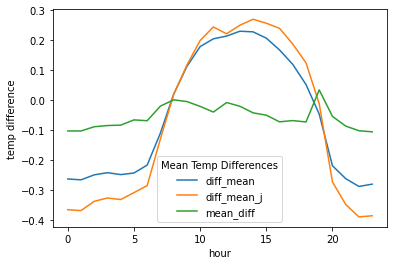

In [4]:
newdf["mean_diff"] = abs(newdf['diff_mean']) - abs(newdf['diff_mean_j'])
newdf.reset_index(inplace=True,drop = False)
mydata = newdf[['hour','diff_mean','diff_mean_j','mean_diff']]
mydata = mydata.melt('hour',var_name='Mean Temp Differences', value_name='temp difference')
sns.lineplot(data =mydata, x = 'hour',y = 'temp difference',hue='Mean Temp Differences')
plt.tight_layout()
plt.savefig(F"{figdir}/temp-diffs-hourly.png",bbox_inches='tight', dpi = 200)
plt.show()

In [5]:
# read in 2022 dataset and initialize datetime + get hour value for each observation
df = pd.read_csv(F'{writedir}/alldata.csv')
df['md'] = pd.to_datetime(df.time,format = '%Y-%m-%d %H:%M:%S')
df['hour'] = df['md'].apply(lambda x: hr_func(x))

# get list of data columns
log_cols = [ x for x in df.columns if x[:3] == "Log" ]

def mean_correct_height_step(data,x,hour):
    if data == True:
        return x + hours.at[hour,"diff_mean"]
    else:
        return x + hours_j.at[hour,"diff_mean_j"]

## Apply step correction

for i in hours.index:
    for k in [True,False]:
        for j in log_cols:
            mylist = [mean_correct_height_step(k,x,i) for x in df[j]]
            if k:
                name = F'{j}_step'
            else:
                name = F'{j}_step_j'
            df[name] = mylist

# filter out unneeded columns
df = df.iloc[:,10:]

### Elevation corrections

I applied the dry-adiabatic decrease of 1K per 100m height gained as in the below quotation:

>Since the height above sea level was not used as a criterion to choose the LCD locations, we incorporated the influence of the altitude directly with a dry-adiabatic decrease of 1 K per 100 m (Salvato et al., 2003), which was chosen since heatwave periods with a rather dry atmosphere were analyzed. This altitude corrected temperature (to the height of Bern-Zollikofen, 553 m.a.s.l.) is further referred as corrected temperature. The mean UHI intensity per heatwave was then used as the response variable in the three resulting models.

From the paper Moritz et al. 2021 (?)

However, this is likely not appropriate for the location at the lake (log 202) as the heat would imply evaporation from the Bielersee lake. The below table summarizes the elevation differences to the reference point (Log_7) located at the Swiss Meteo Monitoring station.

In [6]:
elevations = {"Log_202":430, "Log_201":432,"Log_203":433,"Log_204":430,"Log_205":439,"Log_206":437,"Log_207":430}
d_f=pd.DataFrame({'elevation': elevations})
d_f['elevation_diff'] = d_f.elevation.apply(lambda x: x-430)
d_f['temp_diff_dry'] = d_f.elevation_diff.apply(lambda x: (x/100))

def elevation_correction(j,x):
    mykey = j[:7]
    return x + d_f.at[mykey,'temp_diff_dry']

log_cols = [ x for x in df.columns if x[:3] == "Log" ]

for j in log_cols:
    mylist = [elevation_correction(j,x) for x in df[j]]
    df[j] = mylist

d_f

,elevation,elevation_diff,temp_diff_dry
Log_201,432,2,0.02
Log_202,430,0,0.00
Log_203,433,3,0.03
Log_204,430,0,0.00
Log_205,439,9,0.09
Log_206,437,7,0.07
Log_207,430,0,0.00


In [7]:
df.to_csv(F'{writedir}/data_22_corrected_elevation_height.csv')

In [8]:
df

,md,hour,Log_203_step,Log_202_step,Log_201_step,Log_205_step,Log_204_step,Log_206_step,Log_207_step,Log_203_step_j,Log_202_step_j,Log_201_step_j,Log_205_step_j,Log_204_step_j,Log_206_step_j,Log_207_step_j
0,2022-07-09 00:00:00,0,20.460149,20.049149,20.069149,19.377149,18.716149,15.168149,18.146149,20.35479,19.94379,19.96379,19.27179,18.61079,15.06279,18.04079
1,2022-07-09 00:10:00,0,20.365149,19.954149,19.974149,19.187149,18.526149,14.307149,17.290149,20.25979,19.84879,19.86879,19.08179,18.42079,14.20179,17.18479
2,2022-07-09 00:20:00,0,20.365149,19.858149,19.783149,19.092149,18.336149,13.732149,16.147149,20.25979,19.75279,19.67779,18.98679,18.23079,13.62679,16.04179
3,2022-07-09 00:30:00,0,20.174149,19.763149,19.783149,18.141149,18.336149,13.540149,15.671149,20.06879,19.65779,19.67779,18.03579,18.23079,13.43479,15.56579
4,2022-07-09 00:40:00,0,20.079149,19.573149,19.688149,17.950149,18.146149,13.828149,14.620149,19.97379,19.46779,19.58279,17.84479,18.04079,13.72279,14.51479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,2022-08-11 09:20:00,9,20.651149,21.958149,22.073149,21.570149,20.049149,20.881149,20.049149,20.54579,21.85279,21.96779,21.46479,19.94379,20.77579,19.94379
4809,2022-08-11 09:30:00,9,21.032149,22.341149,22.169149,21.952149,20.621149,20.977149,20.239149,20.92679,22.23579,22.06379,21.84679,20.51579,20.87179,20.13379
4810,2022-08-11 09:40:00,9,21.128149,22.820149,22.361149,22.622149,21.098149,20.977149,20.811149,21.02279,22.71479,22.25579,22.51679,20.99279,20.87179,20.70579
4811,2022-08-11 09:50:00,9,21.223149,23.686149,22.265149,22.814149,21.862149,21.454149,21.002149,21.11779,23.58079,22.15979,22.70879,21.75679,21.34879,20.89679
